In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
import eleanor

In [22]:
coords = (47.729, 9.8238)
star = eleanor.Source(sector=4, coords = coords)


INFO: Found cached file /home/david/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-1-3-cal-0510-0322_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-1-3-cal-0510-0322_tess_v2_bkg.fits with expected size 65286720. [astroquery.query]
INFO: Found cached file /home/david/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-1-3-cal-0510-0322_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-1-3-cal-0510-0322_tess_v2_pc.fits with expected size 130665600. [astroquery.query]


In [4]:
#data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

In [5]:
"""plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('CC CET');"""

"plt.figure(figsize=(15,5))\n\nq = data.quality == 0\n\nplt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')\nplt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')\nplt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')\nplt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')\nplt.ylabel('Normalized Flux')\nplt.xlabel('Time [BJD - 2457000]')\nplt.title('CC CET');"

In [6]:
#data.save(directory='eleanor_files/')

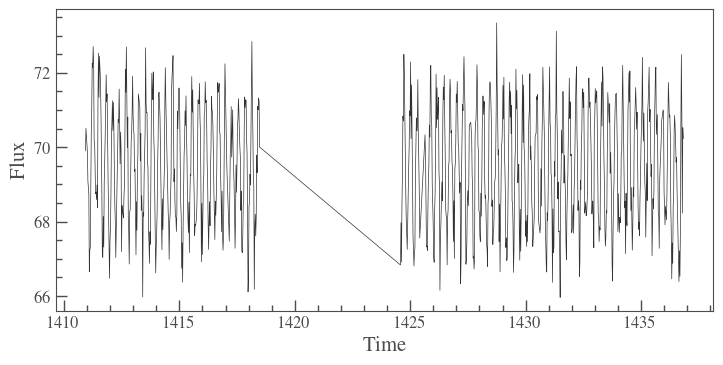

In [7]:
data = fits.getdata('eleanor_files/hlsp_eleanor_tess_ffi_tic337219837_s04_tess_v1.0.0_lc.fits')
q = (data['QUALITY'] == 0)
lc = lk.LightCurve(time = data['Time'][q], flux= data['CORR_FLUX'][q], flux_err = data['FLUX_ERR'][q])

#lc = data.to_lightkurve()
lc.plot()

0.08435600925846706 h


/home/david/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(5.0, 75.0)

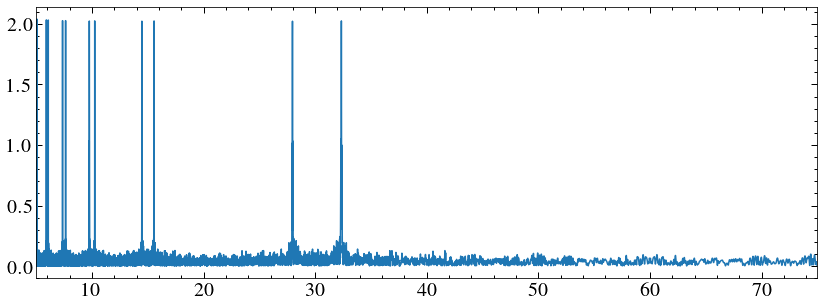

In [31]:
pg = lc.to_periodogram(oversample_factor=10,minimum_period=5*u.minute, maximum_period=10*u.day)
plt.plot(pg.period.to(u.minute), pg.power)
#plt.xscale('log')
print(pg.period_at_max_power.to(u.hour))
#plt.xlim((5*u.minute).to(u.hour).value, (35*u.minute).to(u.hour).value)
plt.xlim(5, 75)

6.883503232597658 h


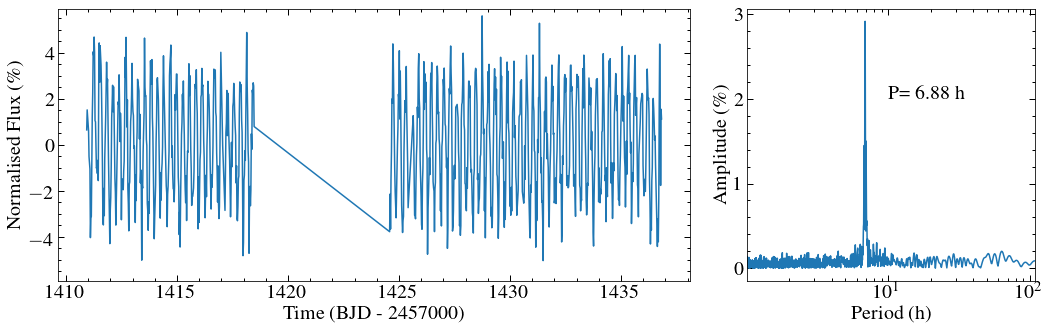

In [34]:
lc1 = lk.LightCurve(time = lc.time, flux= (lc.flux/np.median(lc.flux))-1, flux_err = lc.flux_err/np.median(lc.flux) )
pg1 = lc1.to_periodogram(oversample_factor=10,minimum_period=1*u.hour, maximum_period=10*u.day)
print(pg1.period_at_max_power.to(u.hour)) 
    
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 3, figure=fig)

plt.subplot(gs[:2])
plt.plot(lc1.time, (lc1.flux)*100)
plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)
#plt.ylim(0.93, 1.07)
plt.ylim(-5.9, 5.9)

plt.subplot(gs[2:])
plt.plot(pg1.period.to(u.hour), pg1.power*100)
plt.xscale('log')
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
plt.xlim(1.01, 109)
plt.annotate('P={0:10.2f}'.format(pg1.period_at_max_power.to(u.hour)), (10, 2.))
plt.tight_layout()
plt.savefig('plots/cc_cet_tess.pdf')

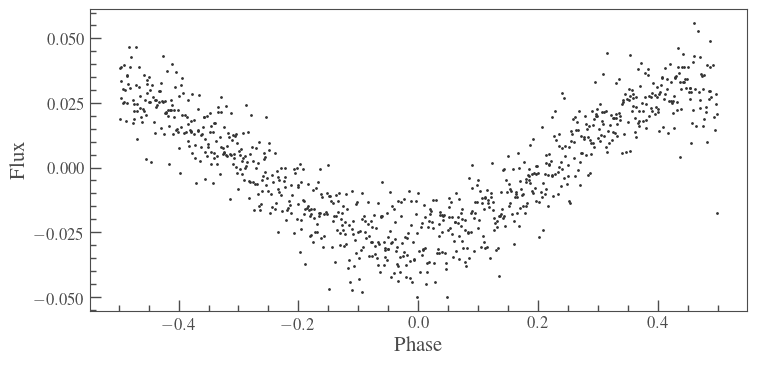

In [10]:
#lc2 = lc1.fold(pg1.period_at_max_power)
lc1.fold(pg1.period_at_max_power).scatter()

Is there anything if we subtract out the orbital period?

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency             phase       
    -------------------- ------------------ -------------------
    0.029212765917992642 3.4876681108646053 -1.7464606309277202
[4.40179319e-04 2.87218306e-04 4.09206685e-01]


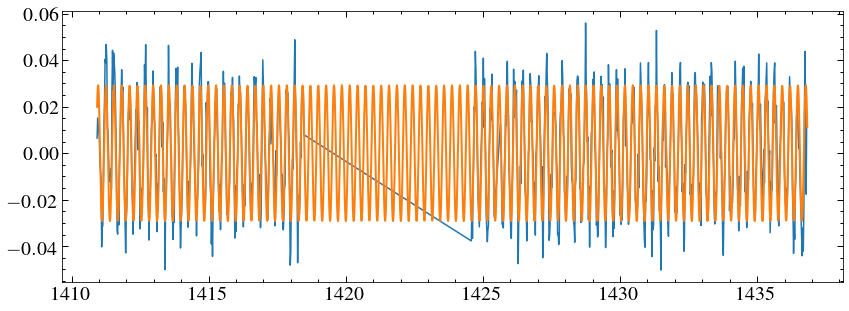

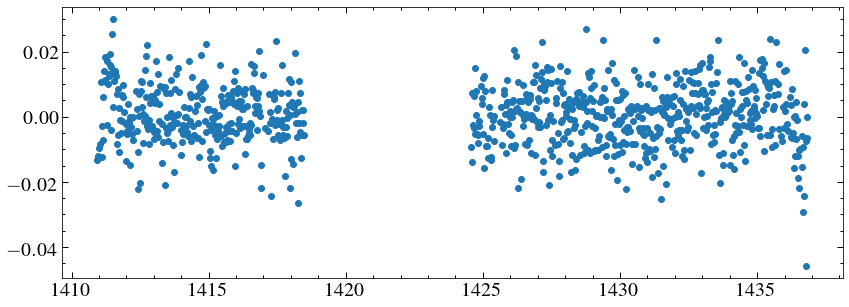

In [11]:
fitter = fitting.LevMarLSQFitter()


sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod, lc1.time, lc1.flux, weights = 1/lc1.flux_err)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 
timefit = np.linspace(lc1.time[0], lc1.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit(lc1.time))

/home/david/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


15.001484165827225 min


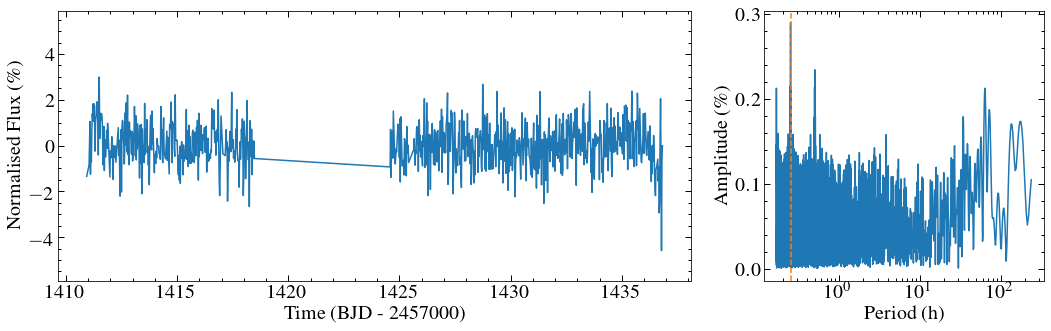

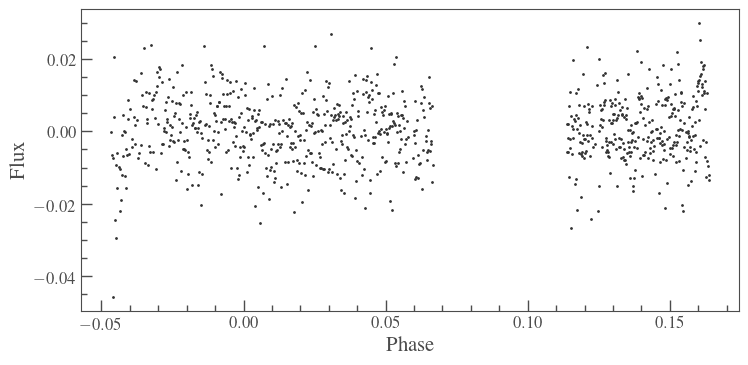

In [45]:
lc2 = lk.LightCurve(time = lc1.time, flux= lc1.flux-sin_fit(lc1.time), flux_err = lc1.flux_err)


pg2 = lc2.to_periodogram(oversample_factor=10,minimum_period=10*u.minute, maximum_period=10*u.day)
    
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 3, figure=fig)

plt.subplot(gs[:2])
plt.plot(lc2.time, (lc2.flux)*100)
plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)
#plt.ylim(0.93, 1.07)
plt.ylim(-5.9, 5.9)

plt.subplot(gs[2:])
plt.plot(pg2.period.to(u.hour), pg2.power*100)
plt.xscale('log')
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#plt.xlim(1.01, 109)
#plt.annotate('P={0:10.2f}\n(known binary \n period :( )'.format(pg2.period_at_max_power.to(u.hour)), (10, 2.))
print(pg2.period_at_max_power.to(u.minute))
plt.axvline(pg2.period_at_max_power.to(u.hour).value, ls='--', c='C1')
plt.tight_layout()
plt.show()
lc2.fold(pg2.period_at_max_power).scatter()

Not really, no. But good to see we can find the period, worth getting all of the other stars?

In [118]:
savdat = Table([lc.time, lc.flux, lc.flux_err], names=['#TIME(d)', 'COUNTS', 'ERROR'])
ascii.write(savdat, 'cc_cet_tess_s4_30m_lc.dat', format='basic', overwrite=True)

Got the COS lightcurve here as well

In [119]:
coslc = Table.read('CC_CET_COS_30s_lc.ecsv')
coslc.sort('TIME')

19.478163149917496 min


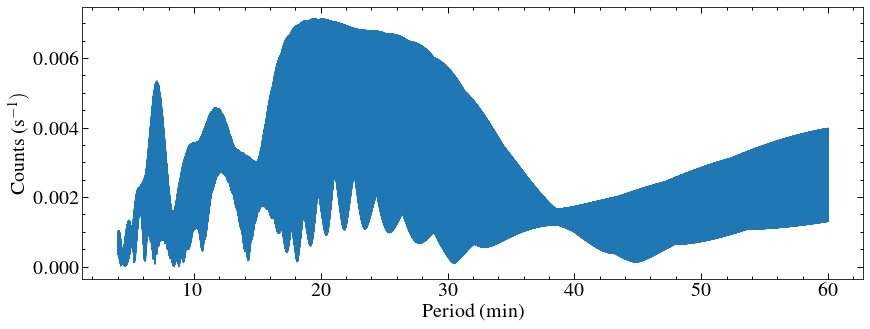

In [135]:

clc = lk.LightCurve(time=coslc['TIME'], flux=(coslc['FLUX']/np.mean(coslc['FLUX']))-1, flux_err=coslc['ERROR']/np.mean(coslc['FLUX'])).remove_outliers(sigma=5)
#args = np.argsort(clc['TIME'])
#clc.sort()
cpg = clc.to_periodogram(oversample_factor=10,minimum_period=240*u.second, maximum_period=1*u.hour)
plt.plot(cpg.period.to(u.min), cpg.power)
plt.xlabel('Period (min)')
plt.ylabel('Counts (s$^{-1})$')

cperiod = cpg.period_at_max_power 
print(cperiod.to(u.min))

In [100]:
#clcfold = clc.fold(19/(24*60))
#clcfold.errorbar()

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency           phase       
    -------------------- ----------------- ------------------
    0.006751916759139113 83.10299701945313 -535042.1664872002
[7.13932244e-04 1.79161081e+00 1.04488976e+05]
17.327894921321768 min


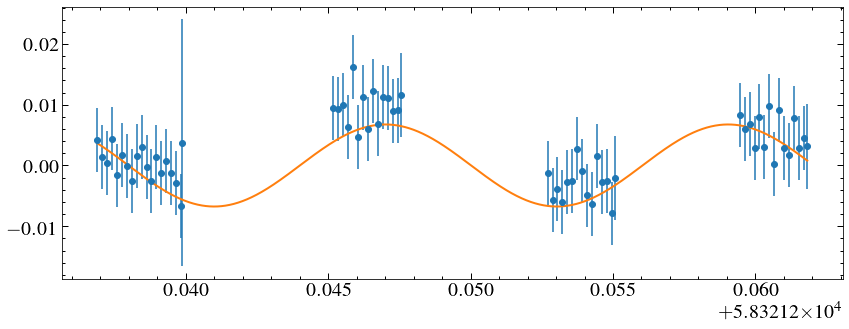

In [139]:
clc = lk.LightCurve(time=coslc['TIME'], flux=(coslc['FLUX']/np.mean(coslc['FLUX']))-1, flux_err=coslc['ERROR']/np.mean(coslc['FLUX'])).remove_outliers(sigma=5)

clc = clc[64:]
sin_mod =  models.Sine1D(amplitude=cpg.max_power, frequency= cpg.frequency_at_max_power.value)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod,clc.time, clc.flux, weights = 1/clc.flux_err)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.errorbar(clc.time, clc.flux, yerr=clc.flux_err, marker='o', ls='none') 
timefit = np.linspace(clc.time[0], clc.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
print(((1/sin_fit.frequency)*u.day).to(u.min))